# Baseline

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [2]:
# Load data
transform = transforms.Compose([
    transforms.ToTensor()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Divide the data into train, val and test sets

bs = 16

train_set, val_set = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_set, batch_size=bs,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(test_set, batch_size=bs,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"train shape: {len(train_set)} samples,", f"validation shape: {len(val_set)} samples,", f"test shape: {len(test_set)} samples")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train shape: 40000 samples, validation shape: 10000 samples, test shape: 10000 samples


In [3]:
# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Image batch dimensions: torch.Size([16, 3, 32, 32])
Image label dimensions: torch.Size([16])
Device: cuda:0


In [124]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1, stride=1),            # [batch, 8, 32, 32]
            nn.ReLU(True),
            nn.Conv2d(8, 12, 3, padding=1, stride=1),           # [batch, 12, 16, 16]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
			      nn.Conv2d(12, 16, 3, padding=1, stride=1),           # [batch, 16, 8, 8]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)

        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 12, 3, padding=1, stride=1),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(12, 3, 3, padding=1, stride=1),
            nn.Sigmoid()

			      # nn.ConvTranspose2d(16, 12, 2, stride=2),  # [batch, 12, 16, 16]
            # nn.ReLU(),
            # nn.ConvTranspose2d(12, 3, 2, stride=2),   # [batch, 3, 32, 32]
            # nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [84]:
# initialize the NN
net = CAE().to(device)
print(net)

# hyperparameters
learning_rate = 0.001
NUM_EPOCHS = 20

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

CAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [85]:
# training pipeline

def train(net, trainloader, valloader, criterion, optimizer, NUM_EPOCHS):
    train_loss = []
    val_loss = []

    for epoch in range(NUM_EPOCHS):
        running_loss_train = 0.0
        running_loss_val = 0.0

        for data_train in trainloader:
            img_train, _ = data_train # no need for the labels
            img_train = img_train.to(device)
            optimizer.zero_grad()
            outputs = net(img_train)[1]

            loss_train = criterion(outputs, img_train)
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item()
        
        loss_train_epoch = running_loss_train / len(trainloader)
        train_loss.append(loss_train_epoch)


        with torch.no_grad():
          for data_val in valloader:
              # get the inputs
              img_val, _ = data_val # no need for the labels
              img_val = img_val.to(device)
              outputs = net(img_val)[1]
              loss_val = criterion(outputs, img_val)
              running_loss_val += loss_val.item()

        loss_val_epoch = running_loss_val / len(valloader)
        val_loss.append(loss_val_epoch) 


        print(f'Epoch {epoch+1} of {NUM_EPOCHS}: Train Loss = {loss_train_epoch} | Validation Loss = {loss_val_epoch}')
        

    return train_loss, val_loss

In [86]:
# training our model
train_loss, val_loss = train(net, trainloader, valloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1 of 20: Train Loss = 0.5866244091033935 | Validation Loss = 0.5713420016750409
Epoch 2 of 20: Train Loss = 0.5691443795204163 | Validation Loss = 0.5674402565713141
Epoch 3 of 20: Train Loss = 0.5661987323760986 | Validation Loss = 0.5654965737822709
Epoch 4 of 20: Train Loss = 0.5650225933074952 | Validation Loss = 0.5645665985763453
Epoch 5 of 20: Train Loss = 0.5642688225746155 | Validation Loss = 0.5639490166287513
Epoch 6 of 20: Train Loss = 0.5637012064933777 | Validation Loss = 0.5634648162088577
Epoch 7 of 20: Train Loss = 0.5632667924880982 | Validation Loss = 0.5631814728117293
Epoch 8 of 20: Train Loss = 0.5629173965454102 | Validation Loss = 0.5627672816537748
Epoch 9 of 20: Train Loss = 0.5626411026954651 | Validation Loss = 0.5624444230346922
Epoch 10 of 20: Train Loss = 0.5623608782768249 | Validation Loss = 0.562216050685591
Epoch 11 of 20: Train Loss = 0.5621499643325806 | Validation Loss = 0.5620818844266758
Epoch 12 of 20: Train Loss = 0.5619678332328797 | Val

Test loss = 0.5616998566184074


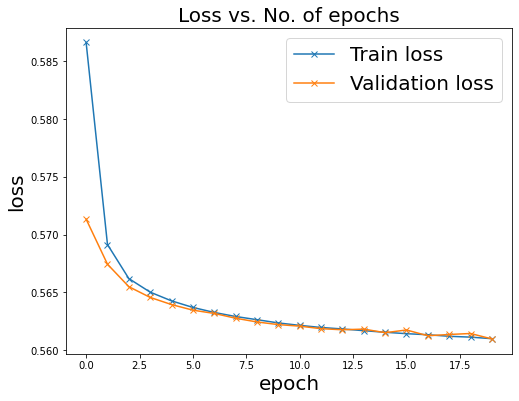

In [91]:
# testing our model
running_loss = 0.0

with torch.no_grad():
  for data_test in testloader:
      # get the inputs
      img, _ = data_test # no need for the labels
      img = img.to(device)
      outputs = net(img)[1]
      loss = criterion(outputs, img)
      running_loss += loss.item()

print(f"Test loss = {running_loss / len(testloader)}")

# plot the evolution of the error with epochs
def plot_losses(history, name = "Loss vs. No. of epochs", label=None):
    plt.plot(history, '-x', label=label)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(name, fontsize=20)

plt.figure(figsize=[8, 6])
plot_losses(train_loss, label="Train loss")
plot_losses(val_loss, label="Validation loss")
plt.legend(fontsize=20)
plt.show()

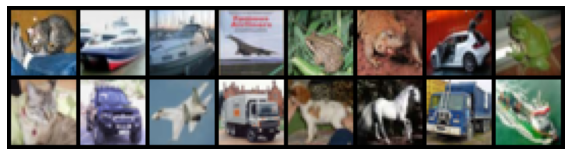

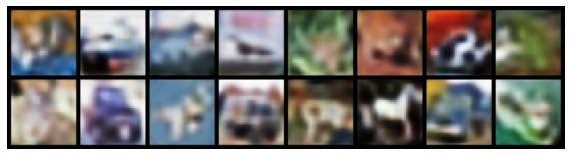

In [88]:
def imshow(img):
    plt.figure(figsize=[10, 10])
    npimg = img.cpu().numpy()
  
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:16, :, :]))

images = Variable(images.cuda())

decoded_imgs = net(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs[:16, :, :].data))

In [10]:
# What is the size of the latent space representation of the above network?

size_of_the_network = ((8 - 3 + 2 * 1) / 1 + 1) ** 2 * 16
print(f"the size of the default network = ", size_of_the_network)

the size of the default network =  1024.0


In [11]:
((16-2)/2 + 1)**2 * 16

1024.0

# Other architectures

In [125]:
class CAE_modified(nn.Module):
    def __init__(self):
        super(CAE_modified, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 3, padding=1, stride=1),            # [batch, 8, 32, 32]
            nn.ReLU(True),
            nn.Conv2d(12, 24, 3, padding=1, stride=1),           # [batch, 12, 16, 16]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
			      nn.Conv2d(24, 48, 3, padding=1, stride=1),           # [batch, 16, 8, 8]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)

        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(48, 24, 3, padding=1, stride=1),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(24, 3, 3, padding=1, stride=1),
            nn.Sigmoid()

			      # nn.ConvTranspose2d(16, 12, 2, stride=2),  # [batch, 12, 16, 16]
            # nn.ReLU(),
            # nn.ConvTranspose2d(12, 3, 2, stride=2),   # [batch, 3, 32, 32]
            # nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [126]:
# What is the size of the latent space representation of the above network?

size_of_the_network = ((8 - 3 + 2 * 1) / 1 + 1) ** 2 * 48
print(f"the size of the default network = ", size_of_the_network)

the size of the default network =  3072.0


In [127]:
# initialize the NN
net_mod = CAE_modified().to(device)
print(net_mod)

# hyperparameters
learning_rate = 0.001
NUM_EPOCHS = 20

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net_mod.parameters(), lr=learning_rate)

CAE_modified(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(24, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [128]:
# training our model
train_loss, val_loss = train(net_mod, trainloader, valloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1 of 20: Train Loss = 0.5684806019186973 | Validation Loss = 0.5626028790950776
Epoch 2 of 20: Train Loss = 0.560709218788147 | Validation Loss = 0.5596182241439819
Epoch 3 of 20: Train Loss = 0.5588442430138588 | Validation Loss = 0.558284446144104
Epoch 4 of 20: Train Loss = 0.5578110099554062 | Validation Loss = 0.5573753883838654
Epoch 5 of 20: Train Loss = 0.5570198112130165 | Validation Loss = 0.556597781085968
Epoch 6 of 20: Train Loss = 0.5563856921315193 | Validation Loss = 0.5560440021038056
Epoch 7 of 20: Train Loss = 0.5559179810166359 | Validation Loss = 0.5555943523406982
Epoch 8 of 20: Train Loss = 0.5556091731786728 | Validation Loss = 0.5555110243320465
Epoch 9 of 20: Train Loss = 0.5553141864299774 | Validation Loss = 0.555095705318451
Epoch 10 of 20: Train Loss = 0.5551144614100456 | Validation Loss = 0.5551957451820374
Epoch 11 of 20: Train Loss = 0.5549780658364296 | Validation Loss = 0.5550766111373902
Epoch 12 of 20: Train Loss = 0.5548412844061852 | Valida

Test loss = 0.5547823906898498


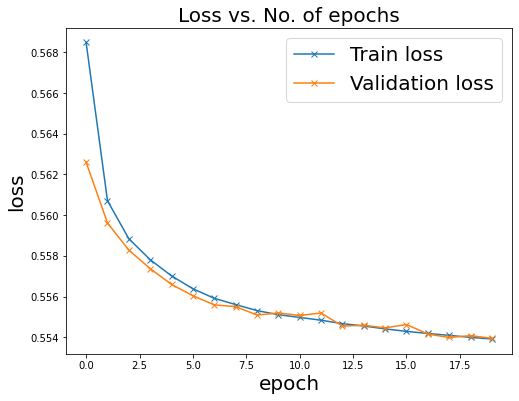

In [130]:
# testing our model
running_loss = 0.0

with torch.no_grad():
  for data_test in testloader:
      # get the inputs
      img, _ = data_test # no need for the labels
      img = img.to(device)
      outputs = net_mod(img)[1]
      loss = criterion(outputs, img)
      running_loss += loss.item()

print(f"Test loss = {running_loss / len(testloader)}")

# plot the evolution of the error with epochs
def plot_losses(history, name = "Loss vs. No. of epochs", label=None):
    plt.plot(history, '-x', label=label)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(name, fontsize=20)

plt.figure(figsize=[8, 6])
plot_losses(train_loss, label="Train loss")
plot_losses(val_loss, label="Validation loss")
plt.legend(fontsize=20)
plt.show()

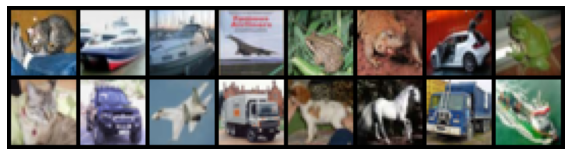

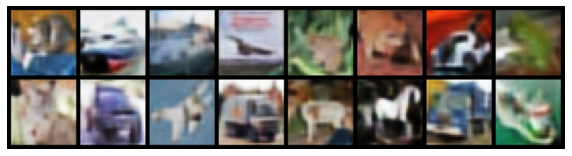

In [101]:
# visualization of the output

def imshow(img):
    plt.figure(figsize=[10, 10])
    npimg = img.cpu().numpy()
  
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:16, :, :]))

images = Variable(images.cuda())

decoded_imgs = net_mod(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs[:16, :, :].data))

torch.nn.ConvTranspose2d vs torch.nn.Upsample: Transpose is learning parameter while Up-sampling is no-learning parameters. Using Up-samling for faster inference or training because it does not require to update weight or compute gradient. ConvTranspose2d is learnable upsampling then, which should perform better.

Let's try a new architecture with the same number of channels in encoder and create new decoder with ConvTranspose2d increased the number of intermidiate layers in decoder.

In [18]:
class CAE2(nn.Module):
    def __init__(self):
        super(CAE2, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(8, 12, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(12, 16, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
  
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(12, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [19]:
# What is the size of the latent space representation of the above network?

size_of_the_network = ((8 - 4 + 2 * 1) / 2 + 1) ** 2 * 16
print(f"the size of the default network = ", size_of_the_network)

the size of the default network =  256.0


In [131]:
class CAE1(nn.Module):
    def __init__(self):
        super(CAE1, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 48, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(48, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [104]:
# What is the size of the latent space representation of the above network?

size_of_the_network = ((8 - 4 + 2 * 1) / 2 + 1) ** 2 * 96
print(f"the size of the default network = ", size_of_the_network)

the size of the default network =  1536.0


In [22]:
# initialize the NN
net1 = CAE2().to(device)
print(net1)

# hyperparameters
learning_rate = 0.001
NUM_EPOCHS = 20

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=learning_rate)

CAE2(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(12, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [23]:
# training our model
train_loss, val_loss = train(net1, trainloader, valloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1 of 20: Train Loss = 0.6064667617797852 | Validation Loss = 0.587741810425072
Epoch 2 of 20: Train Loss = 0.5854346923828125 | Validation Loss = 0.5834639501419796
Epoch 3 of 20: Train Loss = 0.5824606543540954 | Validation Loss = 0.5811641314986405
Epoch 4 of 20: Train Loss = 0.5790123607635498 | Validation Loss = 0.5750658246362286
Epoch 5 of 20: Train Loss = 0.5723581037521362 | Validation Loss = 0.570892357522515
Epoch 6 of 20: Train Loss = 0.5700237314224244 | Validation Loss = 0.5705689229782979
Epoch 7 of 20: Train Loss = 0.5686384828567504 | Validation Loss = 0.568227669236007
Epoch 8 of 20: Train Loss = 0.5671992754936218 | Validation Loss = 0.5665859693934203
Epoch 9 of 20: Train Loss = 0.5651535734176636 | Validation Loss = 0.5644247000384482
Epoch 10 of 20: Train Loss = 0.5638110247611999 | Validation Loss = 0.5633566007492649
Epoch 11 of 20: Train Loss = 0.5628906115531921 | Validation Loss = 0.5626492337056785
Epoch 12 of 20: Train Loss = 0.5622837956428528 | Valid

Test loss = 0.5599192346736883


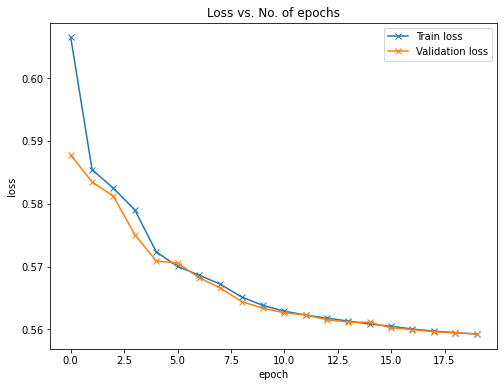

In [24]:
# testing our model
running_loss = 0.0

with torch.no_grad():
  for data_test in testloader:
      # get the inputs
      img, _ = data_test # no need for the labels
      img = img.to(device)
      outputs = net1(img)[1]
      loss = criterion(outputs, img)
      running_loss += loss.item()

print(f"Test loss = {running_loss / len(testloader)}")

# plot the evolution of the error with epochs
def plot_losses(history, name = "Loss vs. No. of epochs", label=None):
    plt.plot(history, '-x', label=label)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(name)

plt.figure(figsize=[8, 6])
plot_losses(train_loss, label="Train loss")
plot_losses(val_loss, label="Validation loss")
plt.legend()
plt.show()

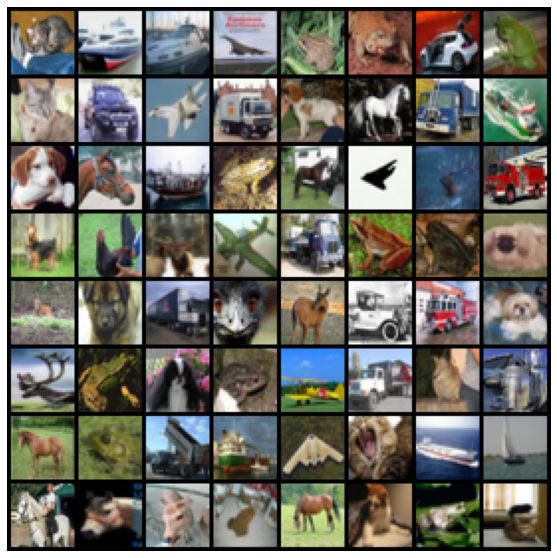

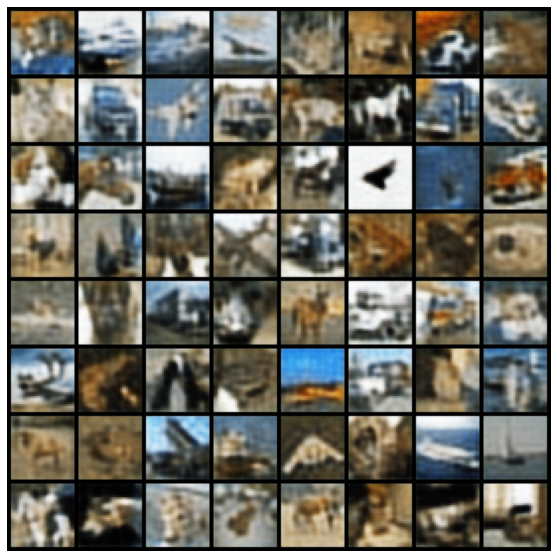

In [25]:
# visualization of the output


def imshow(img):
    plt.figure(figsize=[10, 10])
    npimg = img.cpu().numpy()
  
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

images = Variable(images.cuda())

decoded_imgs = net1(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

More channels.

In [132]:
# initialize the NN
net2 = CAE1().to(device)
print(net2)

# hyperparameters
learning_rate = 0.001
NUM_EPOCHS = 20

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

CAE1(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [133]:
# training our model
train_loss, val_loss = train(net2, trainloader, valloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1 of 20: Train Loss = 0.57132646651268 | Validation Loss = 0.5600450697898864
Epoch 2 of 20: Train Loss = 0.5580888643622398 | Validation Loss = 0.5559912383079528
Epoch 3 of 20: Train Loss = 0.5551384339213371 | Validation Loss = 0.5544671602725982
Epoch 4 of 20: Train Loss = 0.5538026365756988 | Validation Loss = 0.5543985109329224
Epoch 5 of 20: Train Loss = 0.5526931427836418 | Validation Loss = 0.5522274589538574
Epoch 6 of 20: Train Loss = 0.5519337722897529 | Validation Loss = 0.5519631363391876
Epoch 7 of 20: Train Loss = 0.5513667632102967 | Validation Loss = 0.5508970824718475
Epoch 8 of 20: Train Loss = 0.5510105157732964 | Validation Loss = 0.5521640295505523
Epoch 9 of 20: Train Loss = 0.5507257579565048 | Validation Loss = 0.5506020649433137
Epoch 10 of 20: Train Loss = 0.5505502804279327 | Validation Loss = 0.5505319029808045
Epoch 11 of 20: Train Loss = 0.5503456945300103 | Validation Loss = 0.55058804936409
Epoch 12 of 20: Train Loss = 0.5501652613043785 | Valida

Test loss = 0.550519003534317


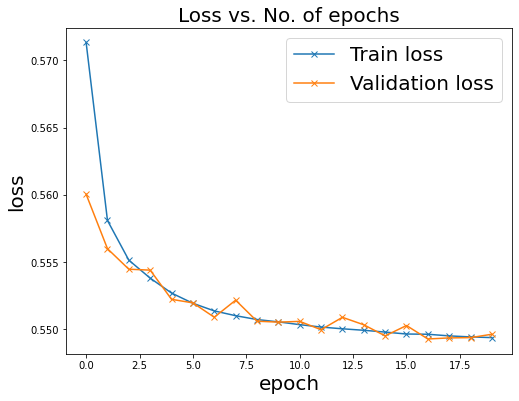

In [134]:
# testing our model
running_loss = 0.0

with torch.no_grad():
  for data_test in testloader:
      # get the inputs
      img, _ = data_test # no need for the labels
      img = img.to(device)
      outputs = net2(img)[1]
      loss = criterion(outputs, img)
      running_loss += loss.item()

print(f"Test loss = {running_loss / len(testloader)}")

# plot the evolution of the error with epochs
def plot_losses(history, name = "Loss vs. No. of epochs", label=None):
    plt.plot(history, '-x', label=label)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(name, fontsize=20)

plt.figure(figsize=[8, 6])
plot_losses(train_loss, label="Train loss")
plot_losses(val_loss, label="Validation loss")
plt.legend(fontsize=20)
plt.show()

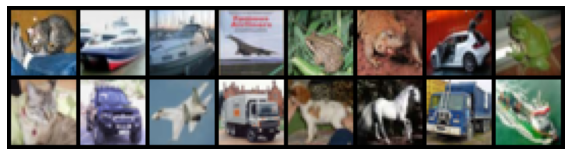

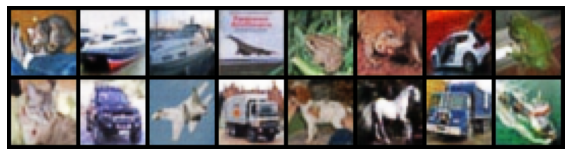

In [108]:
# visualization of the output

def imshow(img):
    plt.figure(figsize=[10, 10])
    npimg = img.cpu().numpy()
  
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:16, :, :]))

images = Variable(images.cuda())

decoded_imgs = net2(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs[:16, :, :].data))

# GrayToColor

In [4]:
!pip install kornia

     |████████████████████████████████| 225kB 2.8MB/s 


In [5]:
import kornia

In [6]:
def imshow(img, grayscale=False):
    plt.figure(figsize=[10, 10])
    npimg = img.cpu().numpy()
    plt.axis('off')
    if grayscale==False:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    elif grayscale==True:
        plt.imshow(npimg, cmap='gray')
    plt.show()

In [27]:
class CAE1(nn.Module):
    def __init__(self):
        super(CAE1, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(20, 60, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(60, 128 , 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

        )
        
        
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(60, 20, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(20, 2, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [28]:
# What is the size of the latent space representation of the above network?

size_of_the_network = ((8 - 4 + 2 * 1) / 2 + 1) ** 2 * 128
print(f"the size of the default network = ", size_of_the_network)

the size of the default network =  2048.0


In [43]:
# initialize the NN
net_2 = CAE1().to(device)
print(net_2)

# hyperparameters
learning_rate = 0.0001
NUM_EPOCHS = 30

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)
# optimizer = optim.SGD(net_2.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)

CAE1(
  (encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(60, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(60, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(20, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [44]:
# training pipeline

def train_gray_to_color(net, trainloader, valloader, criterion, optimizer, NUM_EPOCHS, scheduler=None):
    train_loss = []
    val_loss = []

    for epoch in range(NUM_EPOCHS):
        running_loss_train = 0.0
        running_loss_val = 0.0

        for data_train in trainloader:
            img_train, _ = data_train # no need for the labels

            # Convert an RGB image to YCbCr
            ycbcr_train = kornia.rgb_to_ycbcr(img_train)

            # a greyscale copy of the main image.
            input_train = ycbcr_train[:, 0, :, :].view(-1, 1, 32, 32)

            # C_b and C_r chrominance components
            label_train = ycbcr_train[:, 1:, :, :]

            input_train = input_train.to(device)
            label_train = label_train.to(device)

            optimizer.zero_grad()
            outputs = net(input_train)[1]

            loss_train = criterion(outputs, label_train)
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item()
        
        loss_train_epoch = running_loss_train / len(trainloader)
        train_loss.append(loss_train_epoch)


        with torch.no_grad():
          for data_val in valloader:
              # get the inputs
              img_val, _ = data_val # no need for the labels

              # Convert an RGB image to YCbCr
              ycbcr_val = kornia.rgb_to_ycbcr(img_val)

              # a greyscale copy of the main image.
              input_val = ycbcr_val[:, 0, :, :].view(-1, 1, 32, 32)

              # C_b and C_r chrominance components
              label_val = ycbcr_val[:, 1:, :, :]

              input_val = input_val.to(device)
              label_val = label_val.to(device)

              outputs = net(input_val)[1]
              loss_val = criterion(outputs, label_val)
              running_loss_val += loss_val.item()

        loss_val_epoch = running_loss_val / len(valloader)
        val_loss.append(loss_val_epoch) 
        if scheduler is not None:
          scheduler.step()

        print(f'Epoch {epoch+1} of {NUM_EPOCHS}: Train Loss = {loss_train_epoch} | Validation Loss = {loss_val_epoch}')
        

    return train_loss, val_loss

In [45]:
# training our model
train_loss, val_loss = train_gray_to_color(net_2, trainloader, valloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1 of 18: Train Loss = 0.0032690642495173962 | Validation Loss = 0.0032223448468372226
Epoch 2 of 18: Train Loss = 0.003096569317113608 | Validation Loss = 0.0032334619922563435
Epoch 3 of 18: Train Loss = 0.0030050690888427196 | Validation Loss = 0.003033939470164478
Epoch 4 of 18: Train Loss = 0.0029598195388447495 | Validation Loss = 0.002982442373782396
Epoch 5 of 18: Train Loss = 0.0029220183814875783 | Validation Loss = 0.0029562044471502305
Epoch 6 of 18: Train Loss = 0.0028925231060711667 | Validation Loss = 0.0029234549893066286
Epoch 7 of 18: Train Loss = 0.002871849834593013 | Validation Loss = 0.0029188547387719154
Epoch 8 of 18: Train Loss = 0.0028457573635037987 | Validation Loss = 0.002924603444896638
Epoch 9 of 18: Train Loss = 0.0028259885723702608 | Validation Loss = 0.0028820776004344225
Epoch 10 of 18: Train Loss = 0.0028038108792621643 | Validation Loss = 0.0028723861664533617
Epoch 11 of 18: Train Loss = 0.0027811613225843758 | Validation Loss = 0.00292127934

Test loss = 0.002771280587092042


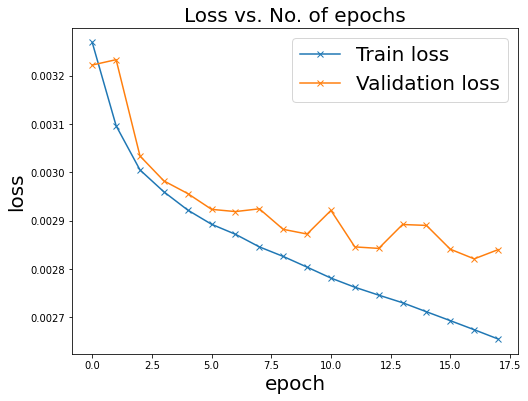

In [46]:
# testing our model
running_loss = 0.0

with torch.no_grad():
  for data_test in testloader:
      # get the inputs
      img, _ = data_test # no need for the labels

      # Convert an RGB image to YCbCr
      ycbcr = kornia.rgb_to_ycbcr(img)

      # a greyscale copy of the main image.
      input = ycbcr[:, 0, :, :].view(-1, 1, 32, 32)

      # C_b and C_r chrominance components
      label = ycbcr[:, 1:, :, :]

      input = input.to(device)
      label = label.to(device)
      outputs = net_2(input)[1]

      loss = criterion(outputs, label)
      running_loss += loss.item()

print(f"Test loss = {running_loss / len(testloader)}")

# plot the evolution of the error with epochs
def plot_losses(history, name = "Loss vs. No. of epochs", label=None):
    plt.plot(history, '-x', label=label)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(name, fontsize=20)

plt.figure(figsize=[8, 6])
plot_losses(train_loss, label="Train loss")
plot_losses(val_loss, label="Validation loss")
plt.legend(fontsize=20)
plt.show()

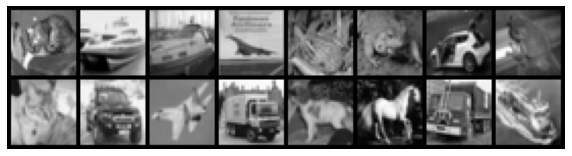

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


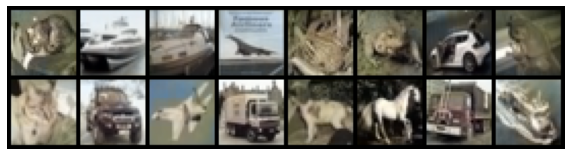

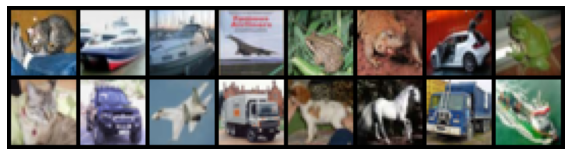

In [47]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = Variable(images.cuda())

# Convert an RGB image to YCbCr
ycbcr = kornia.rgb_to_ycbcr(images)

# a greyscale copy of the main image.
input = ycbcr[:, 0, :, :].view(-1, 1, 32, 32)

# C_b and C_r chrominance components
label = ycbcr[:, 1:, :, :]
input = input.to(device)
label = label.to(device)
outputs = net_2(input)[1]

predictions = torch.cat((input, outputs), dim=1)

imshow(torchvision.utils.make_grid(input[:16, :, :]))
imshow(torchvision.utils.make_grid(kornia.ycbcr_to_rgb(predictions)[:16, :, :].data))
imshow(torchvision.utils.make_grid(images[:16, :, :]))